In [28]:
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.lookup_tools import extractor
import numpy as np
from scipy.optimize import curve_fit
from hist import Hist
import matplotlib.pyplot as plt
from hist import Hist
from coffea.analysis_tools import PackedSelection
from scipy.integrate import quad

from coffea.ml_tools.torch_wrapper import torch_wrapper
from analyzer.core import analyzerModule
from analyzer.matching import object_matching
import pickle

import torch
import torch.nn as nn
import torch.jit as jit
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import pandas as pd

In [29]:
def save_model_for_coffea(model, path):
    # Save the model
    torch.save(model, path)
    
    # Create an empty constants dictionary
    constants = {}
    
    # Save the empty constants
    with open(path.replace('.pt', '/constants.pkl'), 'wb') as f:
        pickle.dump(constants, f)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (979781584.py, line 14)

## get and select events

In [2]:
#TODO: fix path issue
fname = "data/NANOAOD-1200_600.root"
events = NanoEventsFactory.from_root(
    {fname: "Events"},
    schemaclass=NanoAODSchema,
    metadata={"dataset": "DYJets"},
    delayed=False
).events()

/usr/local/lib/python3.10/site-packages/coffea/nanoevents/methods/candidate.py:11: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


In [3]:
def makeCutSet(x, s, *args):
    return [x[s > a] for a in args]

b_tag_wps = [0.0490, 0.2783, 0.7100]

def createObjects(events):
    good_jets = events.Jet[(events.Jet.pt > 30) & (abs(events.Jet.eta) < 2.4)]
    fat_jets = events.FatJet[(events.FatJet.pt > 30) & (abs(events.FatJet.eta) < 2.4)]
    loose_top, med_top, tight_top = makeCutSet(
        fat_jets, fat_jets.particleNet_TvsQCD, 0.58, 0.80, 0.97
    )
    #loose_W, med_W, tight_W = makeCutSet(
    #    fat_jets, fat_jets.particleNet_WvsQCD, 0.7, 0.94, 0.98
    #)

    #deep_top_wp1, deep_top_wp2, deep_top_wp3, deep_top_wp4 = makeCutSet(
    #    fat_jets, fat_jets.deepTag_TvsQCD, 0.436, 0.802, 0.922, 0.989
    #)
    #deep_W_wp1, deep_W_wp2, deep_W_wp3, deep_W_wp4 = makeCutSet(
    #    fat_jets, fat_jets.deepTag_WvsQCD, 0.458, 0.762, 0.918, 0.961
    #)
    loose_b, med_b, tight_b = makeCutSet(
        good_jets, good_jets.btagDeepFlavB, *(b_tag_wps[x] for x in range(3))
    )

    el = events.Electron
    good_electrons = el[
        (el.cutBased == 4)
        & (el.miniPFRelIso_all < 0.1)
        & (el.pt > 30)
        & (abs(el.eta) < 2.4)
    ]
    mu = events.Muon
    good_muons = mu[
        (mu.mediumId) & (mu.miniPFRelIso_all < 0.2) & (mu.pt > 30) & (abs(mu.eta) < 2.4)
    ]
    events["good_jets"] = good_jets
    events["good_electrons"] = good_electrons
    events["good_muons"] = good_muons

    events["loose_bs"] = loose_b
    events["med_bs"] = med_b
    events["tight_bs"] = tight_b

    events["tight_tops"] = tight_top
    # events["med_tops"] = med_top
    # events["loose_tops"] = loose_top

    # events["tight_Ws"] = tight_W
    # events["med_Ws"] = med_W
    # events["loose_Ws"] = loose_W

    # events["deep_top_wp1"] = deep_top_wp1
    # events["deep_top_wp2"] = deep_top_wp2
    # events["deep_top_wp3"] = deep_top_wp3
    # events["deep_top_wp4"] = deep_top_wp4

    # events["deep_W_wp1"] = deep_W_wp1
    # events["deep_W_wp2"] = deep_W_wp2
    # events["deep_W_wp3"] = deep_W_wp3
    # events["deep_W_wp4"] = deep_W_wp4

    return events

def createSelection(events):
    """Baseline selection for the analysis.
Applies the following selection:
- Jets[0].pt > 300
- 4 <= nJets <= 6
- 0 leptons
- 2 medium bjets, at least one of which is tight
- delta_R(med_bjets[0],med_bjets[1]) > 1
    """

    selection = PackedSelection()
    good_jets = events.good_jets
    fat_jets = events.FatJet
    good_muons = events.good_muons
    good_electrons = events.good_electrons
    loose_b = events.loose_bs
    med_b = events.med_bs
    tight_b = events.tight_bs
    tight_top = events.tight_tops
    # selection = PackedSelection()
    filled_jets = ak.pad_none(good_jets, 4, axis=1)
    top_two_dr = ak.fill_none(filled_jets[:, 0].delta_r(filled_jets[:, 1]), False)

    filled_med = ak.pad_none(med_b, 2, axis=1)
    med_dr = ak.fill_none(filled_med[:, 0].delta_r(filled_med[:, 1]), False)
    # selection.add("trigger", (ak.num(good_jets) >= 4) & (ak.num(good_jets) <= 6))
    if "HLT" in events.fields:
        selection.add("hlt", (events.HLT.PFHT1050 | events.HLT.AK8PFJet360_TrimMass30))
    selection.add("highptjet", (ak.fill_none(filled_jets[:, 0].pt > 300, False)))
    selection.add("jets", ((ak.num(good_jets) >= 4) & (ak.num(good_jets) <= 6)))
    selection.add("0Lep", ((ak.num(good_electrons) == 0) & (ak.num(good_muons) == 0)))
    selection.add("2bjet", (ak.num(med_b) >= 2))
    selection.add("1tightbjet", (ak.num(tight_b) >= 1))
    # selection.add("jet_dr", ((top_two_dr < 4) & (top_two_dr > 2)).to_numpy())
    selection.add("b_dr", (med_dr > 1))
    return selection

In [4]:
events = createObjects(events)
mask = createSelection(events).all("highptjet", "jets", "0Lep", "2bjet", "1tightbjet", "b_dr")
events = events[mask]

## get weights

In [5]:
import analyzer.datasets as ds
profile_repo = ds.ProfileRepo()
profile_repo.loadFromDirectory("profiles")
sample_manager = ds.SampleManager()
sample_manager.loadSamplesFromDirectory("datasets", profile_repo)

HT_CUTS = ['50to100', '100to200', '200to300', '300to500', '500to700', '700to1000', '1000to1500', '1500to2000', '2000toInf']

ht_weights = np.zeros(9)

In [6]:
for cut_idx in range(9):
    sample = sample_manager.getSet(f"QCDInclusive2018_HT{HT_CUTS[cut_idx]}")
    ht_weights[cut_idx] = sample.getWeight()

## neural net

In [7]:
class Net(jit.ScriptModule):
        def __init__(self):
            super(Net,self).__init__()
            self.fc1 = nn.Linear(13,13)
            self.fc2 = nn.Linear(13,3)
        def forward(self,x):
            x = F.relu(self.fc1(x))
            x = F.softmax(self.fc2(x),dim=1)
            return x

In [32]:
jets = events.good_jets
flat_jets = ak.flatten(jets)

m3 = jets[:,1:4].sum()
m4 = jets[:,0:4].sum()

ones = ak.ones_like(jets.pt)

imap = {
    "features": {
        "jetOrdinality":    ak.flatten(ak.local_index(jets, axis=1)),
        "jetPT": 		flat_jets.pt,
        "jetEta": 		flat_jets.eta,
        "jetPhi": 		flat_jets.phi,
        "jetBScore": 	flat_jets.btagDeepFlavB,
        "m3M": 			ak.flatten(ones * m3.mass),
        "m3PT": 		ak.flatten(ones * m3.pt),
        "m3Eta": 		ak.flatten(ones * m3.eta),
        "m3Phi": 		ak.flatten(ones * m3.phi),
        "m4M": 			ak.flatten(ones * m4.mass),
        "m4PT":			ak.flatten(ones * m4.pt),
        "m4Eta":		ak.flatten(ones * m4.eta),
        "m4Phi":	    ak.flatten(ones * m4.phi)
    }
}

model = torch.load("jetMatcherNN.pt")

net_input = ak.concatenate([x[:, np.newaxis] for x in imap['features'].values()], axis=1)
net_input = ak.to_numpy(net_input)
net_input = torch.Tensor(net_input)
scl = open('scaler.pkl', 'rb')
scaler = pickle.load(scl)
net_input = scaler.transform(net_input)

outputs = model(torch.Tensor(net_input)).detach().numpy()

stop_probs = outputs[:,0]
charg_probs = outputs[:,1]
other_probs = outputs[:,2]

high_charg_score_mask = ak.unflatten(outputs[:,1] > 0.8, ak.num(jets))
top_3_charg_scores = ak.sort(ak.unflatten(outputs[:,1], ak.num(jets)), axis=1)[:, -3:]
top_3_idx = ak.argsort(ak.unflatten(outputs[:,1], ak.num(jets)), axis=1)[:, -3:]

top_3_charg_score_sum = jets[top_3_idx].sum()
m3_top_3_nn_charg_score = top_3_charg_score_sum.mass
m3_high_nn_charg_score = jets[high_charg_score_mask].sum().mass

/usr/local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [37]:
imap_scaled

<Array [[-1.36, 1.22, ..., 0.168, 1.09], ...] type='20510 * 13 * float64'>

In [39]:
ak.values_astype(retmap["features"],"float32")

NameError: name 'retmap' is not defined

In [36]:
ak.mean(flat_jets.pt)

247.87069722086787

In [9]:
model = torch.load("jetMatcherNN.pt")

def m3_m4_m3NN(ev):
    ev = createObjects(ev)
    mask = createSelection(ev).all("highptjet", "jets", "0Lep", "2bjet", "1tightbjet")
    ev = ev[mask]

    jets = ev.good_jets
    if len(jets) == 0: return 0, 0, 0
    flat_jets = ak.flatten(jets)

    m3 = jets[:,1:4].sum()
    m4 = jets[:,0:4].sum()

    ones = ak.ones_like(jets.pt)

    imap = {
        "features": {
            "jetOrdinality":    ak.flatten(ak.local_index(jets, axis=1)),
            "jetPT": 		flat_jets.pt,
            "jetEta": 		flat_jets.eta,
            "jetPhi": 		flat_jets.phi,
            "jetBScore": 	flat_jets.btagDeepFlavB,
            "m3M": 			ak.flatten(ones * m3.mass),
            "m3PT": 		ak.flatten(ones * m3.pt),
            "m3Eta": 		ak.flatten(ones * m3.eta),
            "m3Phi": 		ak.flatten(ones * m3.phi),
            "m4M": 			ak.flatten(ones * m4.mass),
            "m4PT":			ak.flatten(ones * m4.pt),
            "m4Eta":		ak.flatten(ones * m4.eta),
            "m4Phi":	    ak.flatten(ones * m4.phi)
        }
    }

    net_input = ak.concatenate([x[:, np.newaxis] for x in imap['features'].values()], axis=1)
    net_input = ak.to_numpy(net_input)
    net_input = torch.Tensor(net_input)
    scl = open('scaler.pkl', 'rb')
    scaler = pickle.load(scl)
    net_input = scaler.transform(net_input)

    outputs = model(torch.Tensor(net_input)).detach().numpy()
    top_3_idx = ak.argsort(ak.unflatten(outputs[:,1], ak.num(jets)), axis=1)[:, -3:]

    top_3_charg_score_sum = jets[top_3_idx].sum()
    m3_top_3_nn_charg_score = top_3_charg_score_sum

    return m3, m4, m3_top_3_nn_charg_score

In [ ]:
d

## histograms

In [26]:
def hist_comparison(mass_point):
    filename = f"data/NANOAOD-{mass_point}.root"
    ev = NanoEventsFactory.from_root(
        {filename: "Events"},
        schemaclass=NanoAODSchema,
        metadata={"dataset": "DYJets"},
        delayed=False
    ).events()
    
    true_mstop, true_mchi = mass_point.split("_")

    m3, _, m3_NN = m3_m4_m3NN(ev)

    hist_naive = Hist.new.Regular(40, 0, 2000, name="naive method 1200_600").Double().fill(
    m3.mass)
    hist_NN = Hist.new.Regular(40, 0, 2000, name="NN chargino mass reconstruction 1200_600").Double().fill(
    m3_NN.mass)

    hist_naive.plot(linewidth=2, label="m24 reco histogram")
    hist_NN.plot(linewidth=2, label="NN reco histogram")

    plt.title(f"Chargino mass reconstruction alg comparison\n m_stop = {true_mstop} GeV, m_chi = {true_mchi} GeV")
    plt.xlabel('$m_{\\chi}$ (GeV)')
    plt.ylabel('n')

    plt.legend()
    plt.show()

/usr/local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


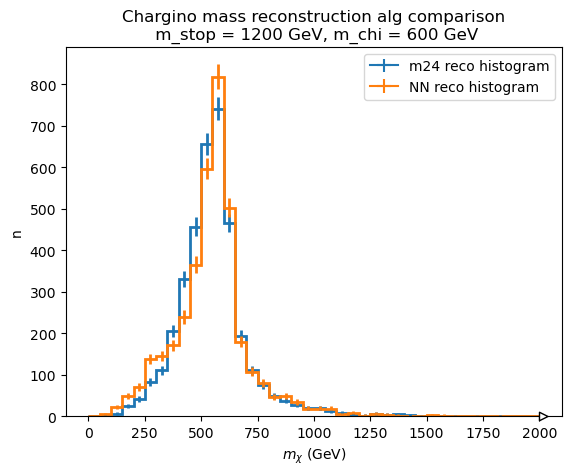

/usr/local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


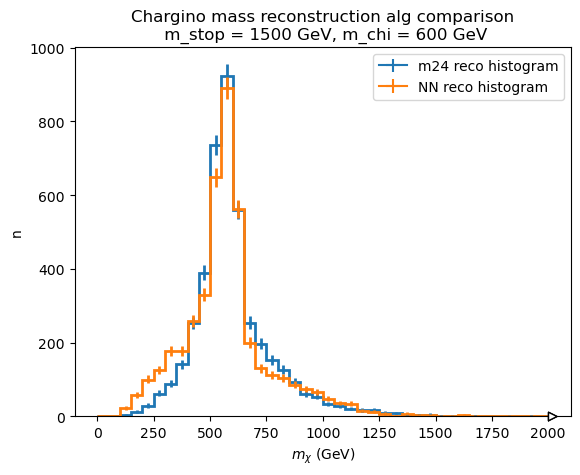

/usr/local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


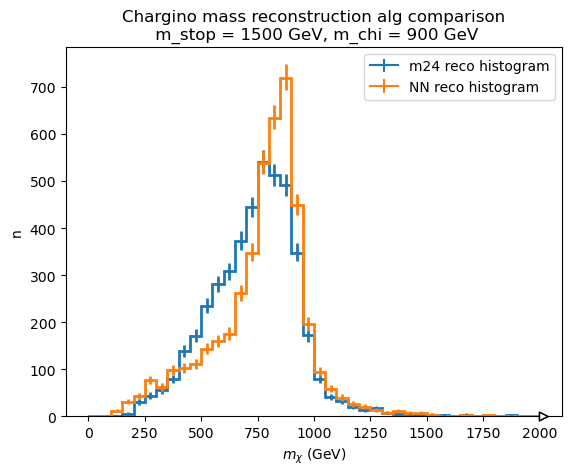

/usr/local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


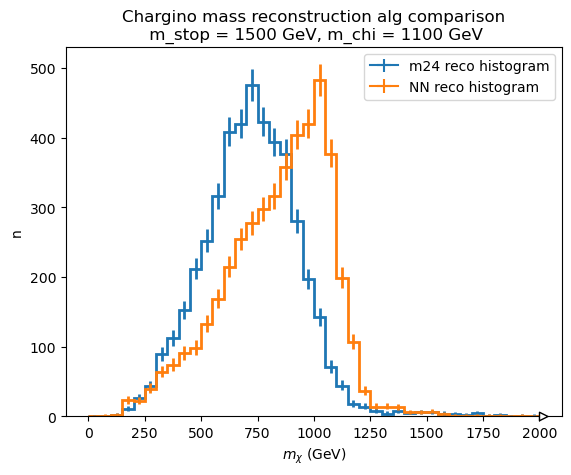

/usr/local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


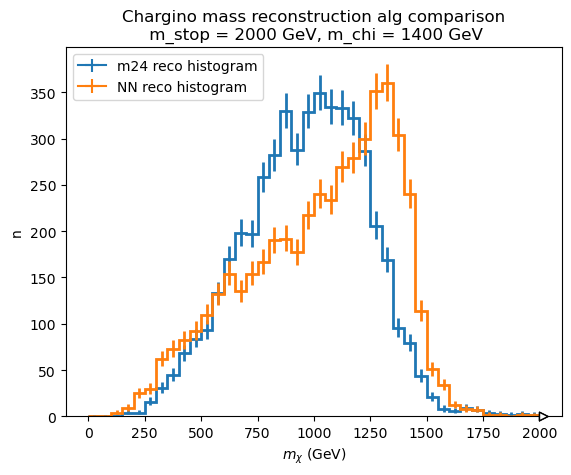

In [27]:
for masspoint in ["1200_600", "1500_600", "1500_900", "1500_1100", "2000_1400"]:
    hist_comparison(masspoint)

In [22]:
m4.mass

<Array [1.21e+03, 1e+03, ..., 1.26e+03, 1.15e+03] type='3708 * float32'>

In [32]:
H, xedges, yedges = np.histogram2d(m4.mass.to_numpy(), m3.mass.to_numpy(), bins=(np.linspace(0, 2000, 51), np.linspace(0, 2000, 51)))
H2, xedges2, yedges2 = np.histogram2d(m4.mass.to_numpy(), m3_top_3_nn_charg_score.to_numpy(), bins=(np.linspace(0, 2000, 51), np.linspace(0, 2000, 51)))

In [31]:
H

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

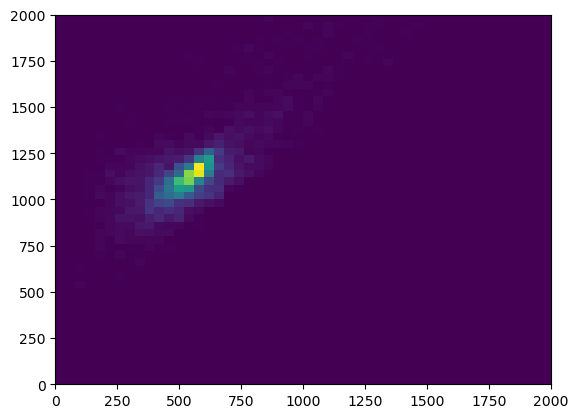

In [33]:
fig, ax = plt.subplots()
X, Y = np.meshgrid(xedges, yedges)
ax.pcolormesh(X, Y, H)

## background

50to100
100to200
200to300
300to500


/usr/local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


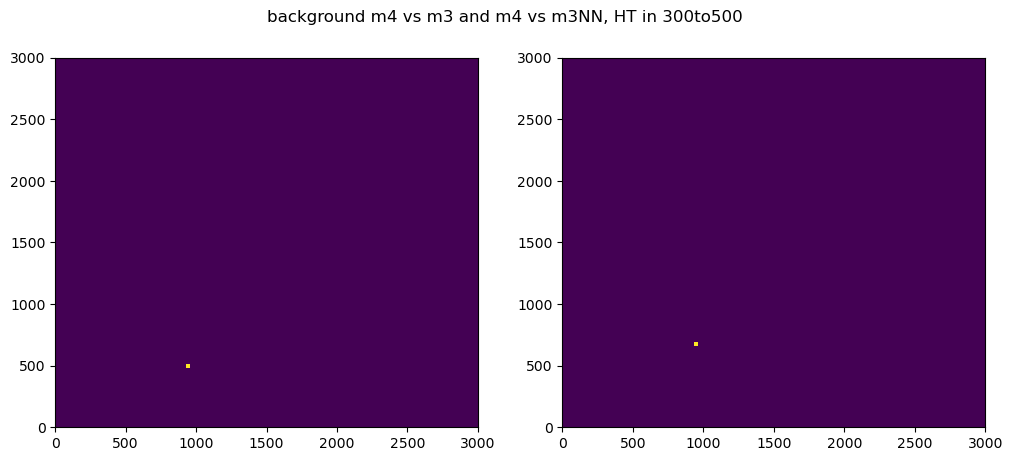

500to700


/usr/local/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:250: RuntimeWarning: Missing cross-reference target for Electron_photonIdx => Photon
  warnings.warn(
/usr/local/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:243: RuntimeWarning: Missing cross-reference index for Photon_electronIdx => Electron
  warnings.warn(
/usr/local/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:243: RuntimeWarning: Missing cross-reference index for Photon_genPartIdx => GenPart
  warnings.warn(
/usr/local/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:243: RuntimeWarning: Missing cross-reference index for Photon_jetIdx => Jet
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
ht

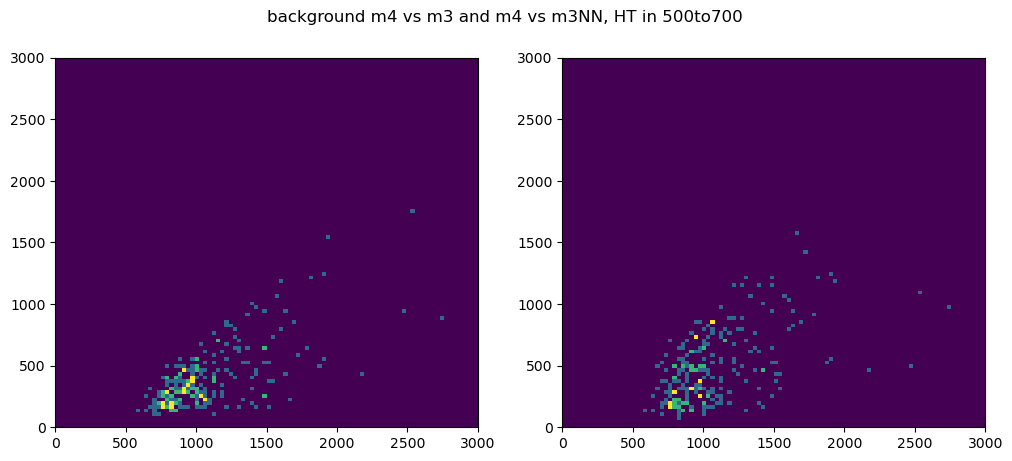

700to1000


/usr/local/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:250: RuntimeWarning: Missing cross-reference target for Electron_photonIdx => Photon
  warnings.warn(
/usr/local/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:243: RuntimeWarning: Missing cross-reference index for Photon_electronIdx => Electron
  warnings.warn(
/usr/local/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:243: RuntimeWarning: Missing cross-reference index for Photon_genPartIdx => GenPart
  warnings.warn(
/usr/local/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:243: RuntimeWarning: Missing cross-reference index for Photon_jetIdx => Jet
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
ht

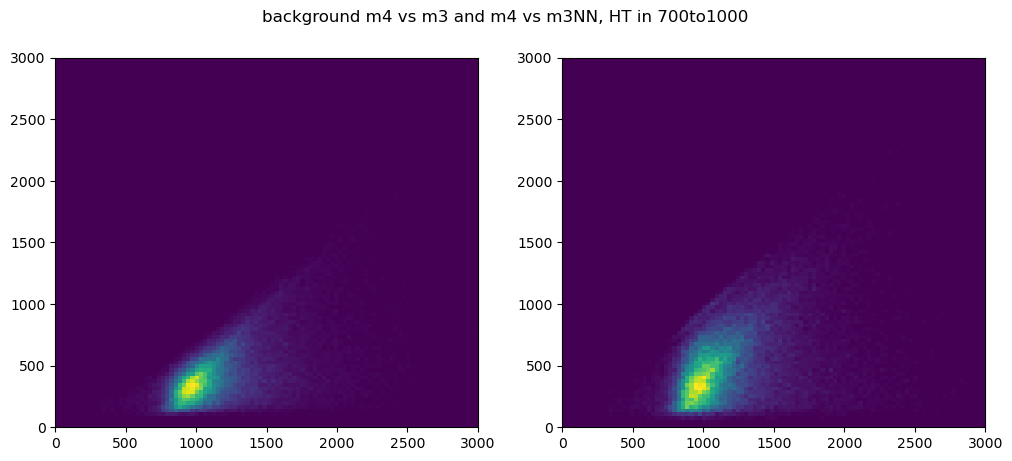

1000to1500


/usr/local/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:250: RuntimeWarning: Missing cross-reference target for Electron_photonIdx => Photon
  warnings.warn(
/usr/local/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:243: RuntimeWarning: Missing cross-reference index for Photon_electronIdx => Electron
  warnings.warn(
/usr/local/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:243: RuntimeWarning: Missing cross-reference index for Photon_genPartIdx => GenPart
  warnings.warn(
/usr/local/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:243: RuntimeWarning: Missing cross-reference index for Photon_jetIdx => Jet
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
ht

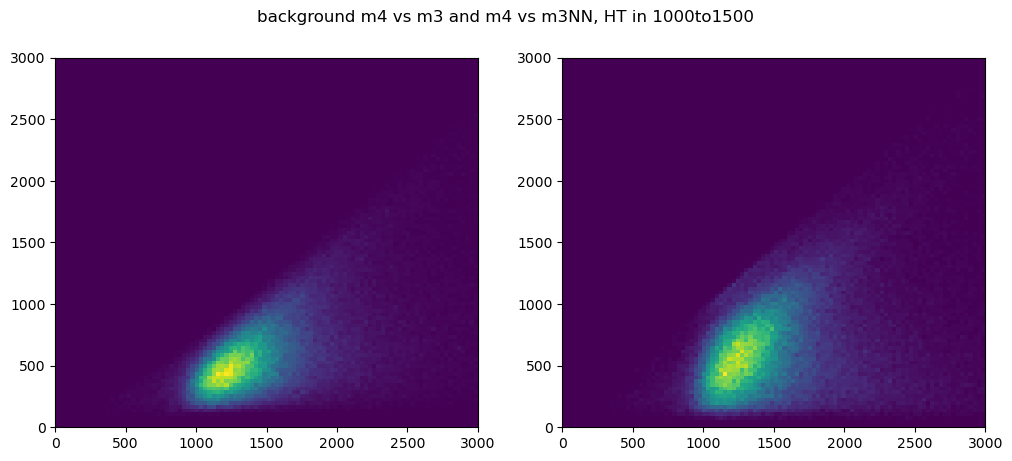

1500to2000


/usr/local/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:250: RuntimeWarning: Missing cross-reference target for Electron_photonIdx => Photon
  warnings.warn(
/usr/local/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:243: RuntimeWarning: Missing cross-reference index for Photon_electronIdx => Electron
  warnings.warn(
/usr/local/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:243: RuntimeWarning: Missing cross-reference index for Photon_genPartIdx => GenPart
  warnings.warn(
/usr/local/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:243: RuntimeWarning: Missing cross-reference index for Photon_jetIdx => Jet
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
ht

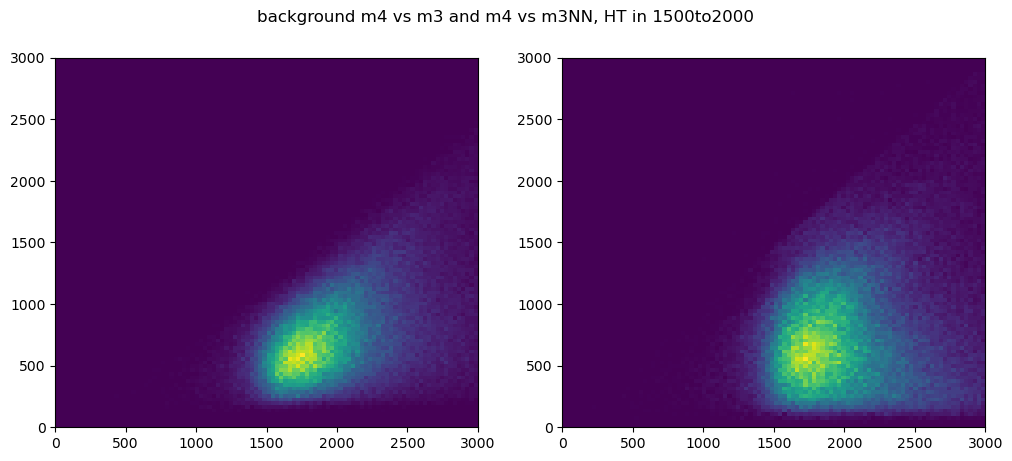

2000toInf


/usr/local/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:250: RuntimeWarning: Missing cross-reference target for Electron_photonIdx => Photon
  warnings.warn(
/usr/local/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:243: RuntimeWarning: Missing cross-reference index for Photon_electronIdx => Electron
  warnings.warn(
/usr/local/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:243: RuntimeWarning: Missing cross-reference index for Photon_genPartIdx => GenPart
  warnings.warn(
/usr/local/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:243: RuntimeWarning: Missing cross-reference index for Photon_jetIdx => Jet
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
ht

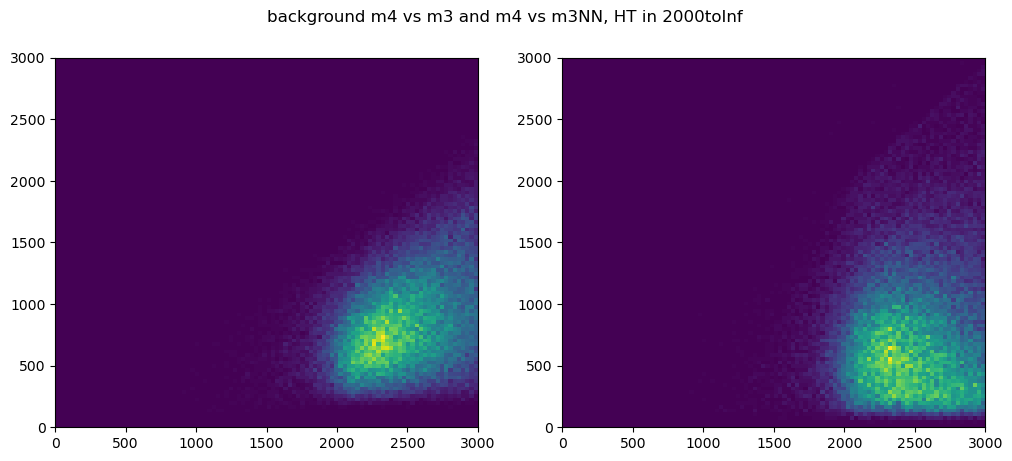

In [61]:
for ht in ['50to100', '100to200', '200to300', '300to500', '500to700', '700to1000', '1000to1500', '1500to2000', '2000toInf']:
    print(ht)
    qcdevents = NanoEventsFactory.from_root(
        {f'data/RunIISummer20UL18NanoAODv9_QCD_HT{ht}.root': "Events"},
        schemaclass=NanoAODSchema,
        metadata={"dataset": "DYJets"},
        delayed=False
    ).events()

    m3, m4, m3NN = m3_m4_m3NN(qcdevents)
    if isinstance(m3, int): continue
    else:
        H, xedges, yedges = np.histogram2d(m3.mass.to_numpy(), m4.mass.to_numpy(), bins=(np.linspace(0, 3000, 101), np.linspace(0, 3000, 101)))
        H2, xedges2, yedges2 = np.histogram2d(m3NN.to_numpy(), m4.mass.to_numpy(), bins=(np.linspace(0, 3000, 101), np.linspace(0, 3000, 101)))

        fig, ax = plt.subplots(1, 2)
        fig.set_figwidth(12)
        X, Y = np.meshgrid(xedges, yedges)
        ax[0].pcolormesh(X, Y, H)
        ax[1].pcolormesh(X, Y, H2)
        plt.suptitle(f"background m4 vs m3 and m4 vs m3NN, HT in {ht}")
        plt.show()